In [7]:
%matplotlib inline

import shutil
import pathlib
import argparse
import subprocess

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
import numpy.linalg
import scipy as sp
import scipy.spatial.distance
import pandas as pd
from PIL import Image
from tqdm import tqdm
# from tqdm import tqdm_notebook as tqdm
from sklearn import metrics

In [15]:
L1 = scipy.spatial.distance.cityblock
L2 = scipy.spatial.distance.euclidean

def load_img(path, grey=True):
    pil_img = Image.open(path)
    if grey:
        pil_img = pil_img.convert('LA')
    return np.array(pil_img) / 255.0


def metric(y_true, y_pred):
    true_0, true_1 = (y_true == 0), (y_true == 1)
    pred_0, pred_1 = (y_pred == 0), (y_pred == 1)
    tp, tn = np.sum(true_1 & pred_1), np.sum(true_0 & pred_0)
    fp, fn = np.sum(true_0 & pred_1), np.sum(true_1 & pred_0)

    precision = tp / (tp + fp) if tp + fp > 0 else None
    recall = tp / (tp + fn) if tp + fn > 0 else None
    return precision, recall

def pr_curve(y_true, y_score):
    precision, recall, threshold = metrics.precision_recall_curve(y_true, y_score)
    ap = metrics.average_precision_score(y_true, y_score)

    fig, ax = plt.subplots(dpi=100)
    ax.step(recall, precision, color='b', alpha=0.2, where='post')
    ax.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('AP = {:.3f}'.format(ap))
    plt.show()
    return precision, recall, threshold, ap

In [19]:
name = 'soccer'
frame_dir = pathlib.Path('./{}_out/'.format(name))
frame_paths = sorted(frame_dir.glob('*.jpg'))
n_frames = len(frame_paths)
truth = './{}_ground.txt'.format(name)

xs = frame_paths
ys = np.zeros(len(frame_paths), dtype=np.int32)

with open(truth, 'r') as f:
    for line in f.readlines()[4:]:
        if '~' in line:
            fs, fe = map(int, line.split('~'))
            ys[fs:fe + 1] = 1
        else:
            ys[int(line)] = 1

In [20]:
def hist_detect(paths, dist_func, nbins=16, pbar=True):
    score = np.zeros(n_frames, dtype=np.float32)

    if pbar:
        paths = tqdm(paths, desc='hist')

    prev_hist = None
    for idx, path in enumerate(paths):
        img = load_img(path, grey=True)
        cur_hist, _ = np.histogram(img, bins=nbins, density=True)
        cur_hist = cur_hist / nbins

        if idx >= 1:
            score[idx] = dist_func(prev_hist, cur_hist)

        prev_hist = cur_hist
        del img
    
    return score

L1_score = hist_detect(xs, L1)
L2_score = hist_detect(xs, L2)

hist: 100%|██████████| 865/865 [00:06<00:00, 127.72it/s]


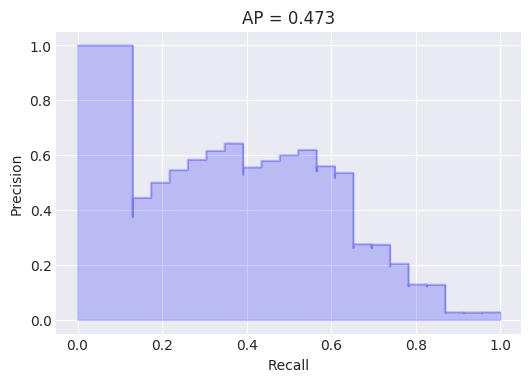

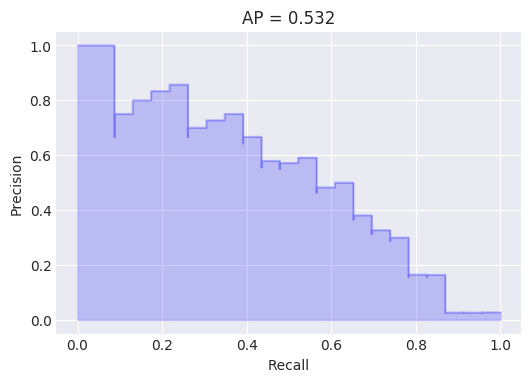

In [21]:
_ = pr_curve(ys, L1_score)
_ = pr_curve(ys, L2_score)